In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.datasets import load_digits
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [2]:
# Sampling 20,000 data entries
n = 767672 
s = 40000
skip = sorted(random.sample(range(1,n+1),n-s))
data = pd.read_csv('zeroopenpowerlifting.csv', skiprows=skip)
data

,Name,Sex,Event,Equipment,Age,AgeClass,Division,BodyweightKg,WeightClassKg,Squat1Kg,...,TotalKg,Place,Wilks,McCulloch,Glossbrenner,IPFPoints,Tested,Country,Federation,Date
0,Brady Curtin,M,SBD,Raw,21.0,20-23,M-OR,88.10,90,160.0,...,510.0,13,329.21,335.79,317.40,474.20,NaN,NaN,GPC-AUS,2018-10-27
1,Dean Panopoulos,M,SBD,Wraps,26.0,24-34,M-OR,81.70,82.5,202.5,...,565.0,4,380.73,380.73,367.63,562.92,NaN,Australia,GPC-AUS,2018-10-27
2,Kaleb Singh,M,SBD,Wraps,22.0,20-23,M-OR,87.20,90,195.0,...,585.0,7,379.71,383.51,366.16,560.25,NaN,NaN,GPC-AUS,2018-10-27
3,Wesley Vick,M,SBD,Wraps,28.0,24-34,M-OR,89.90,90,245.0,...,670.0,3,427.97,427.97,412.43,641.00,NaN,Australia,GPC-AUS,2018-10-27
4,Cassie Morgan,F,SBD,Wraps,22.0,20-23,F-OR,55.70,56,117.5,...,370.0,1,437.18,441.55,386.75,682.75,NaN,NaN,GPC-AUS,2015-05-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,Greg Wheat,M,BD,Raw,50.0,50-54,m2,77.38,82.5,0.0,...,287.5,1,200.55,226.63,193.52,NaN,Yes,USA,NASA,2019-06-22
39996,Justin Jay,M,SBD,Wraps,22.5,20-23,jr,59.92,60,0.0,...,440.0,1,375.72,375.72,366.92,537.06,Yes,USA,NASA,2019-06-22
39997,Trent Gooch,M,SBD,Wraps,22.5,20-23,jr,74.75,75,0.0,...,495.0,2,353.54,353.54,341.65,515.16,Yes,USA,NASA,2019-06-22
39998,Ruben Sanchez,M,SBD,Wraps,25.0,24-34,open,109.95,110,0.0,...,735.0,1,432.60,432.60,413.45,628.72,Yes,USA,NASA,2019-06-22


In [3]:
# Dropping columns not needed for this test
data = data.drop(columns=['Name', 'AgeClass', 'Division',
                          'Squat4Kg', 'Bench4Kg', 'Deadlift4Kg',
                          'Place', 'Tested', 'Country', 'Federation',
                          'Date', 'IPFPoints', 'TotalKg', 'Squat1Kg',
                          'Squat2Kg', 'Squat3Kg','Bench1Kg', 'Bench2Kg',
                          'Bench3Kg', 'Deadlift1Kg', 'Deadlift2Kg',
                          'Deadlift3Kg', 'McCulloch', 'Glossbrenner',
                          'WeightClassKg'])

data.columns
data.isnull().sum()

Sex                   0
Event                 0
Equipment             0
Age                   0
BodyweightKg          0
Best3SquatKg          0
Best3BenchKg          0
Best3DeadliftKg       0
Wilks              2273
dtype: int64

In [4]:
# General dropna just  to clear those without a WILKS
data = data.dropna()

In [5]:
# Dropping athletes who did not compete in complete SBD competitions
indexNames = data[data['Event'] == 'S'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'B'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'D'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SD'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'SB'].index
data.drop(indexNames, inplace=True)

indexNames = data[data['Event'] == 'BD'].index
data.drop(indexNames, inplace=True)
data

,Sex,Event,Equipment,Age,BodyweightKg,Best3SquatKg,Best3BenchKg,Best3DeadliftKg,Wilks
0,M,SBD,Raw,21.0,88.10,170.0,115.0,225.0,329.21
1,M,SBD,Wraps,26.0,81.70,215.0,120.0,230.0,380.73
2,M,SBD,Wraps,22.0,87.20,207.5,127.5,250.0,379.71
3,M,SBD,Wraps,28.0,89.90,270.0,140.0,260.0,427.97
4,F,SBD,Wraps,22.0,55.70,130.0,70.0,170.0,437.18
...,...,...,...,...,...,...,...,...,...
39993,M,SBD,Raw,18.5,81.01,112.5,82.5,167.5,245.55
39996,M,SBD,Wraps,22.5,59.92,152.5,97.5,190.0,375.72
39997,M,SBD,Wraps,22.5,74.75,185.0,115.0,195.0,353.54
39998,M,SBD,Wraps,25.0,109.95,272.5,182.5,280.0,432.60


In [6]:
# Convert string data to numeric
sex = {'M': 1, 'F': 0, 'Mx': 3}
equipment = {'Raw': 0, 'Wraps': 1, 'Multi-ply': 2, 'Single-ply': 3, 'Straps': 4}

data.Sex = [sex[item] for item in data.Sex]
data.Equipment = [equipment[item] for item in data.Equipment]

In [7]:
# Normalise the data, scaling to values between 0-1
scaler = MinMaxScaler(feature_range=(0,1))
data[['Sex', 'Age', 'Equipment', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']] = scaler.fit_transform(data[['Sex', 'Age', 'Equipment', 'BodyweightKg',
        'Wilks', 'Best3BenchKg', 'Best3DeadliftKg', 'Best3SquatKg']])

In [8]:
# So, running 3 different test and training sets.
# First for squats, then bench, finally deadlifts,
# See the model accuracy for predicting someone's lifts.
# Further experiments to see which variables are critical
# to accurate prediction. How accurate can we get with age,
# sex, weight, and equipment?

test_data = data[[ 'Sex', 'Age', 'BodyweightKg', 'Equipment', 'Wilks']]

target_squat = data[['Best3SquatKg']]

target_bench = data[['Best3BenchKg']]

target_dead = data[['Best3DeadliftKg']]

In [9]:
#Prepare the sets
X = test_data
s = target_squat
b = target_bench
d = target_dead

In [10]:
# Split sets into training and test sets
X_train, X_test, s_train, s_test = train_test_split(X, s, test_size=0.1, random_state=3)
X_train, X_test, b_train, b_test = train_test_split(X, b, test_size=0.1, random_state=3)
X_train, X_test, d_train, d_test = train_test_split(X, d, test_size=0.1, random_state=3)

In [11]:
# Prepare random forest models, check r2_scores.
srfregr = RandomForestRegressor(n_estimators=100, max_depth = 30)
brfregr = RandomForestRegressor(n_estimators=100, max_depth = 30)
drfregr = RandomForestRegressor(n_estimators=100, max_depth = 30)

In [12]:
srfregr.fit(X_train, s_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [13]:
S_rfr = srfregr.predict(X_test)
print("R2-score: %.2f" % r2_score(S_rfr , s_test))
print("RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(s_test, S_rfr)))
print("Std: %.2f" % s_test.std())

R2-score: 0.95
RMSE: 0.03
Std: 0.13


In [14]:
brfregr.fit(X_train, b_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [15]:
B_rfr = brfregr.predict(X_test)
print("R2-score: %.2f" % r2_score(B_rfr , b_test))
print("RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(b_test, B_rfr)))
print("Std: %.2f" % b_test.std())

R2-score: 0.89
RMSE: 0.04
Std: 0.12


In [16]:
drfregr.fit(X_train, d_train.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [17]:
D_rfr = drfregr.predict(X_test)
print("R2-score: %.2f" % r2_score(D_rfr , d_test))
print("RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(d_test, D_rfr)))
print("Std: %.2f" % d_test.std())

R2-score: 0.93
RMSE: 0.04
Std: 0.15


In [18]:
#Prepare Lineaar models and check r2_scores
S_linreg = LinearRegression()
B_linreg = LinearRegression()
D_linreg = LinearRegression()

In [19]:
S_linreg.fit(X_train, s_train.values.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [20]:
S_lin = S_linreg.predict(X_test)
print("R2-score: %.2f" % r2_score(S_lin , s_test))
print("RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(s_test, S_lin)))
print("Std: %.2f" % s_test.std())

R2-score: 0.91
RMSE: 0.04
Std: 0.13


In [21]:
B_linreg.fit(X_train, b_train.values.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [22]:
B_lin = B_linreg.predict(X_test)
print("R2-score: %.2f" % r2_score(B_lin , b_test))
print("RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(b_test, B_lin)))
print("Std: %.2f" % b_test.std())

R2-score: 0.85
RMSE: 0.04
Std: 0.12


In [23]:
D_linreg.fit(X_train, d_train.values.ravel())

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [24]:
D_lin = D_linreg.predict(X_test)
print("R2-score: %.2f" % r2_score(D_lin , d_test))
print("RMSE: %.2f" % np.sqrt(metrics.mean_squared_error(d_test, D_lin)))
print("Std: %.2f" % d_test.std())

R2-score: 0.89
RMSE: 0.05
Std: 0.15


In [25]:
sfr_pred = pd.DataFrame(srfregr.predict(X_test))

slr_pred = pd.DataFrame(S_linreg.predict(X_test))


S_bw = pd.DataFrame(X_test['BodyweightKg'])
S_bw = S_bw.reset_index()
S_bw = S_bw.drop(columns = 'index')

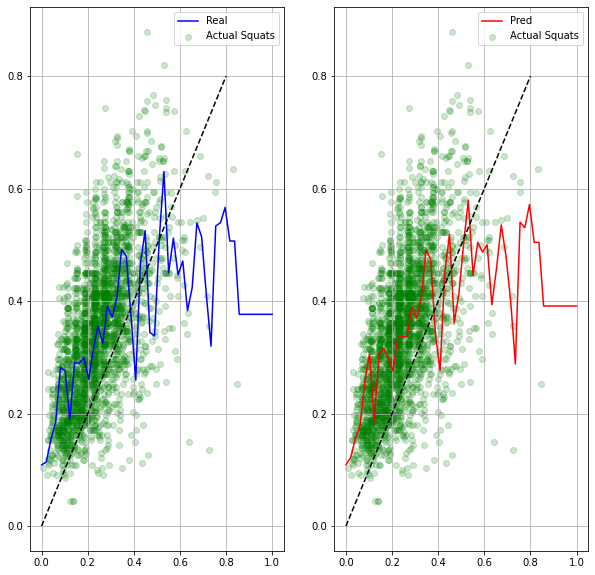

In [27]:
xfit = np.linspace(0, 1)
yfit = RandomForestRegressor().fit(S_bw, sfr_pred.values.ravel()).predict(xfit[:, None])
zfit = RandomForestRegressor().fit(S_bw, s_test.values.ravel()).predict(xfit[:, None])
plt.figure(figsize=(10,10))

plt.subplot(1 , 2, 1)
plt.scatter(S_bw, s_test, color = 'g', label='Actual Squats', alpha=0.2)
plt.plot(xfit, np.sin(zfit), color = 'b', label='Real');
plt.plot([0,0.8], [0,0.8], 'k--')
plt.legend()
plt.grid(True)

plt.subplot(1 , 2, 2)
plt.scatter(S_bw, s_test, color = 'g', label='Actual Squats', alpha=0.2)
plt.plot(xfit, np.sin(yfit), color = 'r', label='Pred');
plt.plot([0,0.8], [0,0.8], 'k--')
plt.legend()
plt.grid(True)

plt.show()

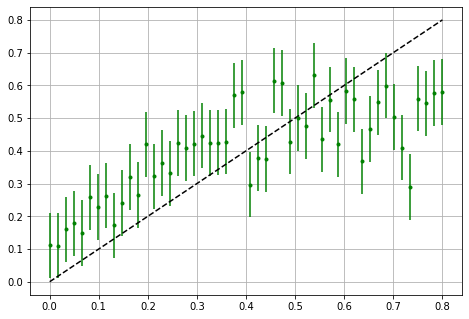

In [28]:
xfit = np.linspace(0, 0.8)
yfit = RandomForestRegressor().fit(S_bw, sfr_pred.values.ravel()).predict(xfit[:, None])
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
plt.errorbar(xfit, yfit, 0.1, fmt='.g')
plt.plot([0,0.8], [0,0.8], 'k--')
ax.grid(True)
plt.show()

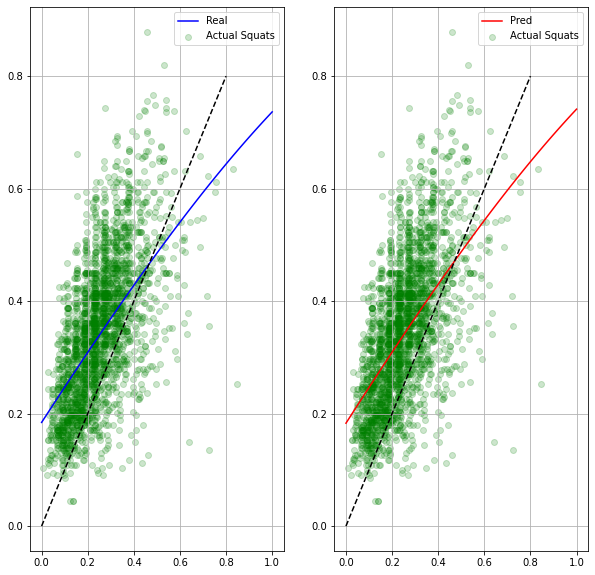

In [29]:
xfit = np.linspace(0, 1)
yfit = LinearRegression().fit(S_bw, slr_pred).predict(xfit[:, None])
zfit = LinearRegression().fit(S_bw, s_test).predict(xfit[:, None])
plt.figure(figsize=(10,10))

plt.subplot(1 , 2, 1)
plt.scatter(S_bw, s_test, color = 'g', label='Actual Squats', alpha=0.2)
#plt.scatter(S_bw, slr_pred, color = 'purple', label='Predicted Squats', alpha=0.2)
plt.plot(xfit, np.sin(zfit), color = 'b', label='Real');
plt.plot([0,0.8], [0,0.8], 'k--')
plt.legend()
plt.grid(True)

plt.subplot(1 , 2, 2)
plt.scatter(S_bw, s_test, color = 'g', label='Actual Squats', alpha=0.2)
#plt.scatter(S_bw, slr_pred, color = 'purple', label='Predicted Squats', alpha=0.2)
plt.plot(xfit, np.sin(yfit), color = 'r', label='Pred');
plt.plot([0,0.8], [0,0.8], 'k--')
plt.legend()
plt.grid(True)

ax.grid(True)
plt.show()

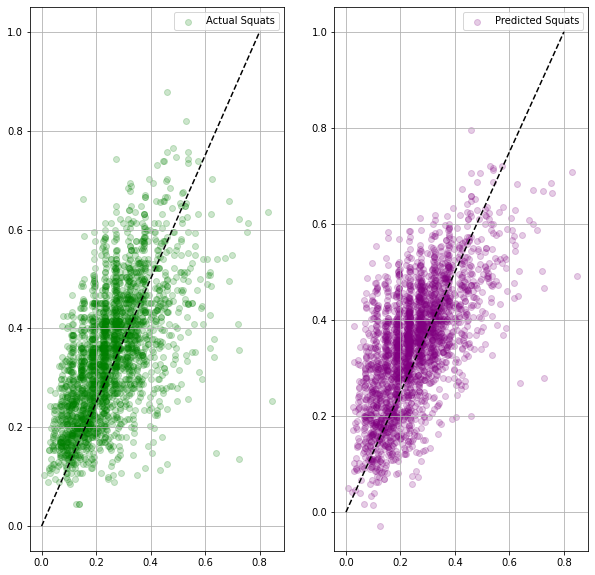

In [30]:
xfit = np.linspace(0, 1)
yfit = LinearRegression().fit(S_bw, slr_pred).predict(xfit[:, None])
zfit = LinearRegression().fit(S_bw, s_test).predict(xfit[:, None])
plt.figure(figsize=(10,10))

plt.subplot(1 , 2, 1)
plt.scatter(S_bw, s_test, color = 'g', label='Actual Squats', alpha=0.2)
plt.plot([0,0.8], [0,1], 'k--')
plt.legend()
plt.grid(True)

plt.subplot(1 , 2, 2)
plt.scatter(S_bw, slr_pred, color = 'purple', label='Predicted Squats', alpha=0.2)
plt.plot([0,0.8], [0,1], 'k--')
plt.legend()
plt.grid(True)

ax.grid(True)
plt.show()